# Introduction (Himmelblau's function)



Let's use ``blop`` to minimize Himmelblau's function, which has four global minima:

In [1]:
from blop.utils import prepare_re_env  # noqa

%run -i $prepare_re_env.__file__ --db-type=temp

Text(0, 0.5, 'x2')

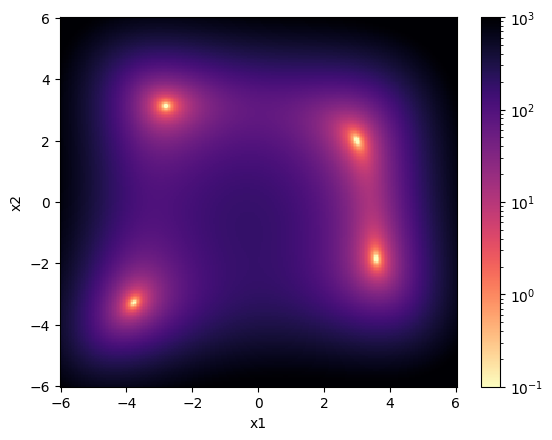

In [2]:
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

from blop.utils import functions

x1 = x2 = np.linspace(-6, 6, 256)
X1, X2 = np.meshgrid(x1, x2)

F = functions.himmelblau(X1, X2)

plt.pcolormesh(x1, x2, F, norm=mpl.colors.LogNorm(vmin=1e-1, vmax=1e3), cmap="magma_r")
plt.colorbar()
plt.xlabel("x1")
plt.ylabel("x2")

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [3]:
from blop import DOF

dofs = [
    DOF(name="x1", search_domain=(-6, 6)),
    DOF(name="x2", search_domain=(-6, 6)),
]

We also need to give the agent something to do. We want our agent to look in the feedback for a variable called 'himmelblau', and try to minimize it.

In [4]:
from blop import Objective

objectives = [Objective(name="himmelblau", description="Himmeblau's function", target="min")]

In our digestion function, we define our objective as a deterministic function of the inputs:

In [5]:
def digestion(df):
    for index, entry in df.iterrows():
        df.loc[index, "himmelblau"] = functions.himmelblau(entry.x1, entry.x2)

    return df

We then combine these ingredients into an agent, giving it an instance of ``databroker`` so that it can see the output of the plans it runs.

In [6]:
from blop import Agent

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    digestion=digestion,
    db=db,
)

Without any data, we can't make any inferences about what the function looks like, and so we can't use any non-trivial acquisition functions. Let's start by quasi-randomly sampling the parameter space, and plotting our model of the function:

2025-03-04 22:05:10.771 INFO: Executing plan <generator object Agent.learn at 0x7f9381914580>


2025-03-04 22:05:10.776 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f93850cb5e0> from 'idle' -> 'running'




Transient Scan ID: 1     Time: 2025-03-04 22:05:10

Persistent Unique Scan ID: '809109f0-0269-4c4e-9c41-11143ebe3859'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:10.8 |     -1.001 |     -0.032 |

|         2 | 22:05:10.8 |     -2.348 |     -0.823 |

|         3 | 22:05:10.8 |     -3.269 |     -1.436 |

|         4 | 22:05:10.8 |     -1.540 |     -1.926 |

|         5 | 22:05:10.9 |      0.303 |     -1.592 |

|         6 | 22:05:10.9 |      0.867 |      0.951 |

|         7 | 22:05:10.9 |     -0.079 |      2.487 |

|         8 | 22:05:10.9 |      0.478 |      3.042 |

|         9 | 22:05:10.9 |      1.829 |      2.903 |

|        10 | 22:05:10.9 |      1.171 |      5.648 |

|        11 | 22:05:10.9 |      2.985 |      4.934 |

|        12 | 22:05:10.9 |      4.258 |      4.451 |

|        13 | 22:05:10.9 |      5.219 |      5.593 |

|        14 | 22:05:10.9 |      5.620 |      1.687 |

|        15 | 22:05:10.9 |      3.112 |      0.485 |

|        16 | 22:05:11.0 |      2.435 |     -0.390 |

|        17 | 22:05:11.0 |      4.644 |     -1.043 |

|        18 | 22:05:11.0 |      4.058 |     -2.995 |

|        19 | 22:05:11.0 |      5.796 |     -3.138 |

|        20 | 22:05:11.0 |      4.942 |     -5.740 |

|        21 | 22:05:11.0 |      3.662 |     -5.029 |

|        22 | 22:05:11.0 |      2.029 |     -4.359 |

|        23 | 22:05:11.0 |      1.442 |     -5.501 |

|        24 | 22:05:11.0 |     -0.652 |     -3.943 |

|        25 | 22:05:11.0 |     -2.645 |     -5.893 |

|        26 | 22:05:11.0 |     -4.901 |     -4.672 |

|        27 | 22:05:11.1 |     -4.362 |     -3.471 |

|        28 | 22:05:11.1 |     -5.261 |     -2.579 |

|        29 | 22:05:11.1 |     -4.725 |      0.128 |

|        30 | 22:05:11.1 |     -3.810 |      2.021 |

|        31 | 22:05:11.1 |     -3.165 |      0.915 |

|        32 | 22:05:11.1 |     -2.446 |      1.344 |

|        33 | 22:05:11.1 |     -2.091 |      3.376 |

|        34 | 22:05:11.1 |     -1.178 |      4.577 |

|        35 | 22:05:11.1 |     -3.468 |      5.986 |

|        36 | 22:05:11.1 |     -5.835 |      4.035 |

+-----------+------------+------------+------------+

generator list_scan ['809109f0'] (scan num: 1)

2025-03-04 22:05:11.983 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f93850cb5e0> from 'running' -> 'idle'


2025-03-04 22:05:11.984 INFO: Cleaned up from plan <generator object Agent.learn at 0x7f9381914580>


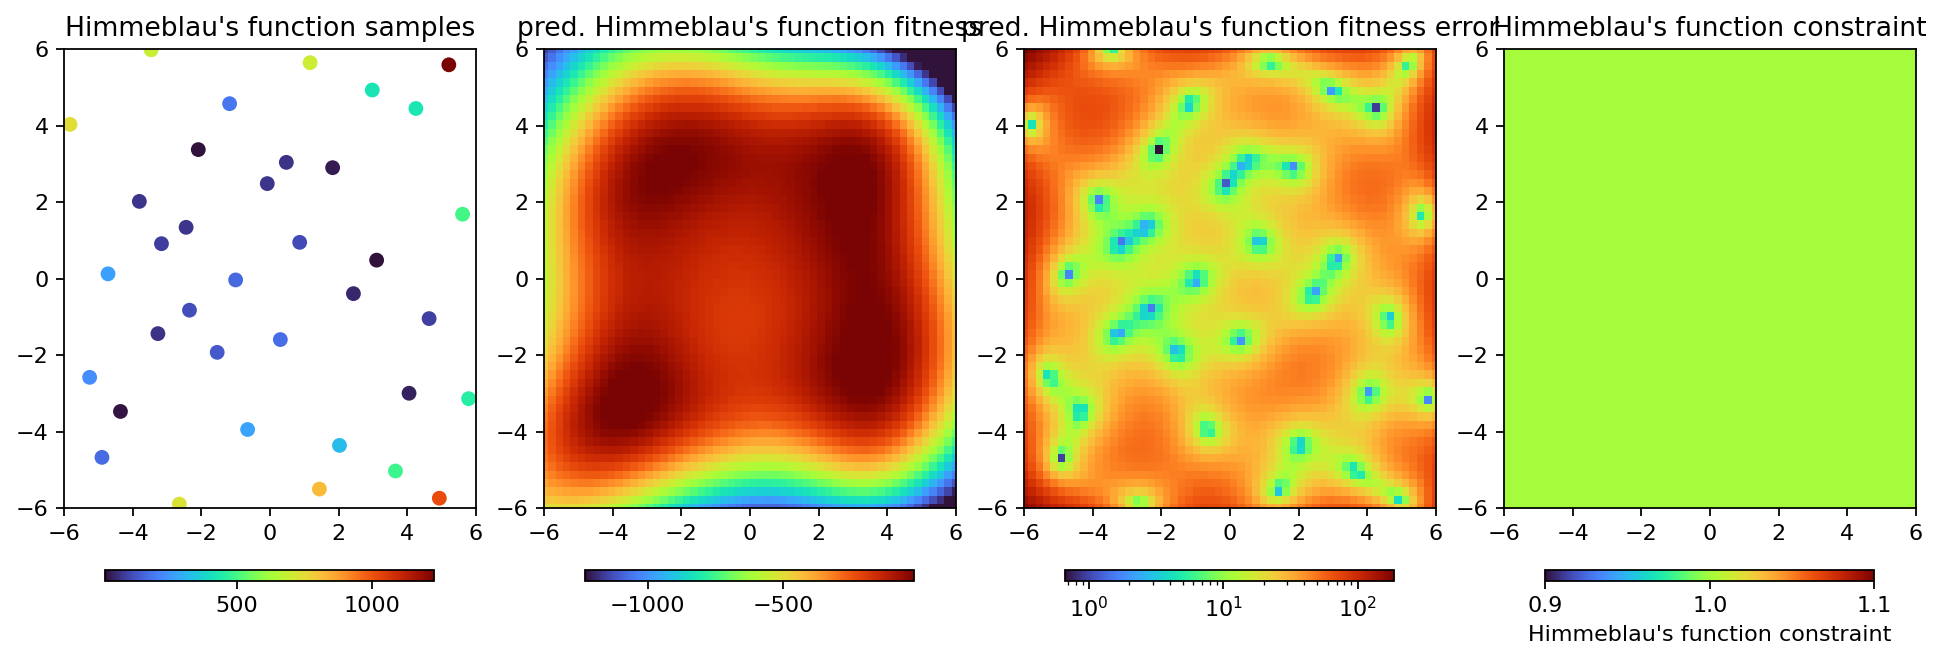

In [7]:
RE(agent.learn("quasi-random", n=36))
agent.plot_objectives()

To decide which points to sample, the agent needs an acquisition function. The available acquisition function are here:

In [8]:
agent.all_acqfs

,identifier,type,multitask_only,description
name,,,,
expected_improvement,ei,analytic,False,"The expected value of max(f(x) - \nu, 0), wher..."
expected_mean,em,analytic,False,The expected value at each input.
noisy_expected_hypervolume_improvement,nehvi,analytic,True,It's like a big box. How big is the box?
probability_of_improvement,pi,analytic,False,The probability that this input improves on th...
upper_confidence_bound,ucb,analytic,False,"The expected value, plus some multiple of the ..."
lower_bound_max_value_entropy,lbmve,monte_carlo,False,"Max entropy search, basically"
monte_carlo_expected_improvement,qei,monte_carlo,False,"The expected value of max(f(x) - \nu, 0), wher..."
monte_carlo_expected_mean,qem,monte_carlo,False,The expected value at each input.
monte_carlo_noisy_expected_hypervolume_improvement,qnehvi,monte_carlo,True,It's like a big box. How big is the box?


Now we can start to learn intelligently. Using the shorthand acquisition functions shown above, we can see the output of a few different ones:

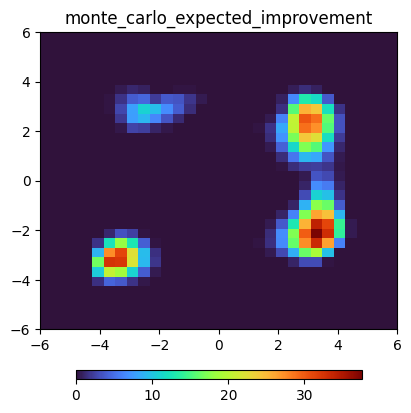

In [9]:
agent.plot_acquisition(acqf="qei")

To decide where to go, the agent will find the inputs that maximize a given acquisition function:

In [10]:
agent.ask("qei", n=1)

{'points': {'x1': [np.float32(3.3690672)], 'x2': [np.float32(-2.1174235)]},
 'acqf_name': 'monte_carlo_expected_improvement',
 'acqf_obj': [np.float64(37.75131373745458)],
 'acqf_kwargs': {'best_f': -14.023744709422457},
 'duration_ms': 130.82541799997216,
 'sequential': True,
 'upsample': 1,
 'read_only_values': tensor([], size=(1, 0))}

We can also ask the agent for multiple points to sample and it will jointly maximize the acquisition function over all sets of inputs, and find the most efficient route between them:

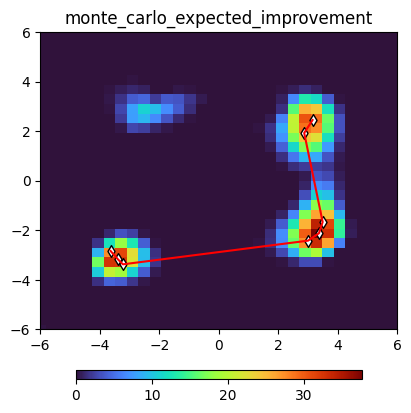

In [11]:
res = agent.ask("qei", n=8, route=True)
agent.plot_acquisition(acqf="qei")
plt.scatter(res["points"]["x1"], res["points"]["x2"], marker="d", facecolor="w", edgecolor="k")
plt.plot(res["points"]["x1"], res["points"]["x2"], color="r")

All of this is automated inside the ``learn`` method, which will find a point (or points) to sample, sample them, and retrain the model and its hyperparameters with the new data. To do 4 learning iterations of 8 points each, we can run

In [12]:
RE(agent.learn("qei", n=4, iterations=8))

2025-03-04 22:05:30.800 INFO: Executing plan <generator object Agent.learn at 0x7f936c174900>


2025-03-04 22:05:30.806 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f93850cb5e0> from 'idle' -> 'running'




Transient Scan ID: 2     Time: 2025-03-04 22:05:33

Persistent Unique Scan ID: 'bc5978d7-37ce-44dc-858f-0187bb2bcb6b'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:33.4 |      3.155 |      2.451 |

|         2 | 22:05:33.4 |      3.368 |     -2.117 |

|         3 | 22:05:33.5 |      3.006 |     -2.398 |

|         4 | 22:05:33.5 |     -3.396 |     -3.161 |

+-----------+------------+------------+------------+

generator list_scan ['bc5978d7'] (scan num: 2)



Transient Scan ID: 3     Time: 2025-03-04 22:05:39

Persistent Unique Scan ID: '276f5667-5341-48c8-a553-fff624eeda25'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:39.0 |     -2.615 |      2.738 |

|         2 | 22:05:39.0 |      2.890 |      2.966 |

|         3 | 22:05:39.0 |      2.737 |      1.813 |

|         4 | 22:05:39.1 |      3.541 |     -1.124 |

+-----------+------------+------------+------------+

generator list_scan ['276f5667'] (scan num: 3)



Transient Scan ID: 4     Time: 2025-03-04 22:05:41

Persistent Unique Scan ID: '4379118a-af98-4b28-9f11-502f940c2fa3'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:41.9 |      3.657 |     -1.947 |

|         2 | 22:05:41.9 |      3.173 |      1.687 |

|         3 | 22:05:41.9 |     -3.788 |     -3.096 |

|         4 | 22:05:41.9 |     -3.787 |     -3.504 |

+-----------+------------+------------+------------+

generator list_scan ['4379118a'] (scan num: 4)



Transient Scan ID: 5     Time: 2025-03-04 22:05:48

Persistent Unique Scan ID: '589624f3-9a4a-450f-86cf-700757aa70b1'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:48.1 |     -2.861 |      3.180 |

|         2 | 22:05:48.1 |     -1.976 |      2.845 |

|         3 | 22:05:48.1 |      2.991 |      2.028 |

|         4 | 22:05:48.1 |      3.637 |     -2.256 |

+-----------+------------+------------+------------+

generator list_scan ['589624f3'] (scan num: 5)



Transient Scan ID: 6     Time: 2025-03-04 22:05:50

Persistent Unique Scan ID: '25fb4002-2a32-463f-9b7b-ae8a2ace500d'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:50.3 |      3.543 |     -1.673 |

|         2 | 22:05:50.3 |      3.544 |     -0.252 |

|         3 | 22:05:50.3 |     -2.743 |      3.097 |

|         4 | 22:05:50.3 |     -2.930 |      3.006 |

+-----------+------------+------------+------------+

generator list_scan ['25fb4002'] (scan num: 6)

/opt/hostedtoolcache/Python/3.10.16/x64/lib/python3.10/site-packages/botorch/optim/optimize.py:273: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL: .')]
Trying again with a new set of initial conditions.
  candidate, acq_value = _optimize_acqf_batch(new_inputs)




Transient Scan ID: 7     Time: 2025-03-04 22:05:52

Persistent Unique Scan ID: '7e6cf2c8-56d7-44bb-802e-424633be456c'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:52.7 |      2.796 |      2.249 |

|         2 | 22:05:52.7 |      3.032 |      1.921 |

|         3 | 22:05:52.7 |     -3.788 |     -3.294 |

|         4 | 22:05:52.7 |     -5.251 |     -4.763 |

+-----------+------------+------------+------------+

generator list_scan ['7e6cf2c8'] (scan num: 7)



Transient Scan ID: 8     Time: 2025-03-04 22:05:57

Persistent Unique Scan ID: '22a04b9a-287d-4e07-bab6-43d3bcb0b4fc'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:05:57.1 |     -3.785 |     -3.286 |

|         2 | 22:05:57.2 |     -3.737 |     -3.259 |

|         3 | 22:05:57.2 |      3.578 |     -1.850 |

|         4 | 22:05:57.2 |      3.641 |     -1.739 |

+-----------+------------+------------+------------+

generator list_scan ['22a04b9a'] (scan num: 8)



Transient Scan ID: 9     Time: 2025-03-04 22:06:00

Persistent Unique Scan ID: '12c28316-e7c0-4567-b505-af7205ae2712'

New stream: 'primary'

+-----------+------------+------------+------------+

|   seq_num |       time |         x1 |         x2 |

+-----------+------------+------------+------------+

|         1 | 22:06:00.2 |      3.576 |     -1.853 |

|         2 | 22:06:00.3 |      3.486 |      0.998 |

|         3 | 22:06:00.3 |      2.990 |      2.008 |

|         4 | 22:06:00.3 |     -3.803 |     -3.296 |

+-----------+------------+------------+------------+

generator list_scan ['12c28316'] (scan num: 9)

2025-03-04 22:06:00.651 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f93850cb5e0> from 'running' -> 'idle'


2025-03-04 22:06:00.652 INFO: Cleaned up from plan <generator object Agent.learn at 0x7f936c174900>


('bc5978d7-37ce-44dc-858f-0187bb2bcb6b',
 '276f5667-5341-48c8-a553-fff624eeda25',
 '4379118a-af98-4b28-9f11-502f940c2fa3',
 '589624f3-9a4a-450f-86cf-700757aa70b1',
 '25fb4002-2a32-463f-9b7b-ae8a2ace500d',
 '7e6cf2c8-56d7-44bb-802e-424633be456c',
 '22a04b9a-287d-4e07-bab6-43d3bcb0b4fc',
 '12c28316-e7c0-4567-b505-af7205ae2712')

Our agent has found all the global minima of Himmelblau's function using Bayesian optimization, and we can ask it for the best point: 

x1                                   -3.784579
x2                                   -3.286191
himmelblau                            0.001567
time             2025-03-04 22:05:57.194514513
acqf          monte_carlo_expected_improvement
Name: 60, dtype: object

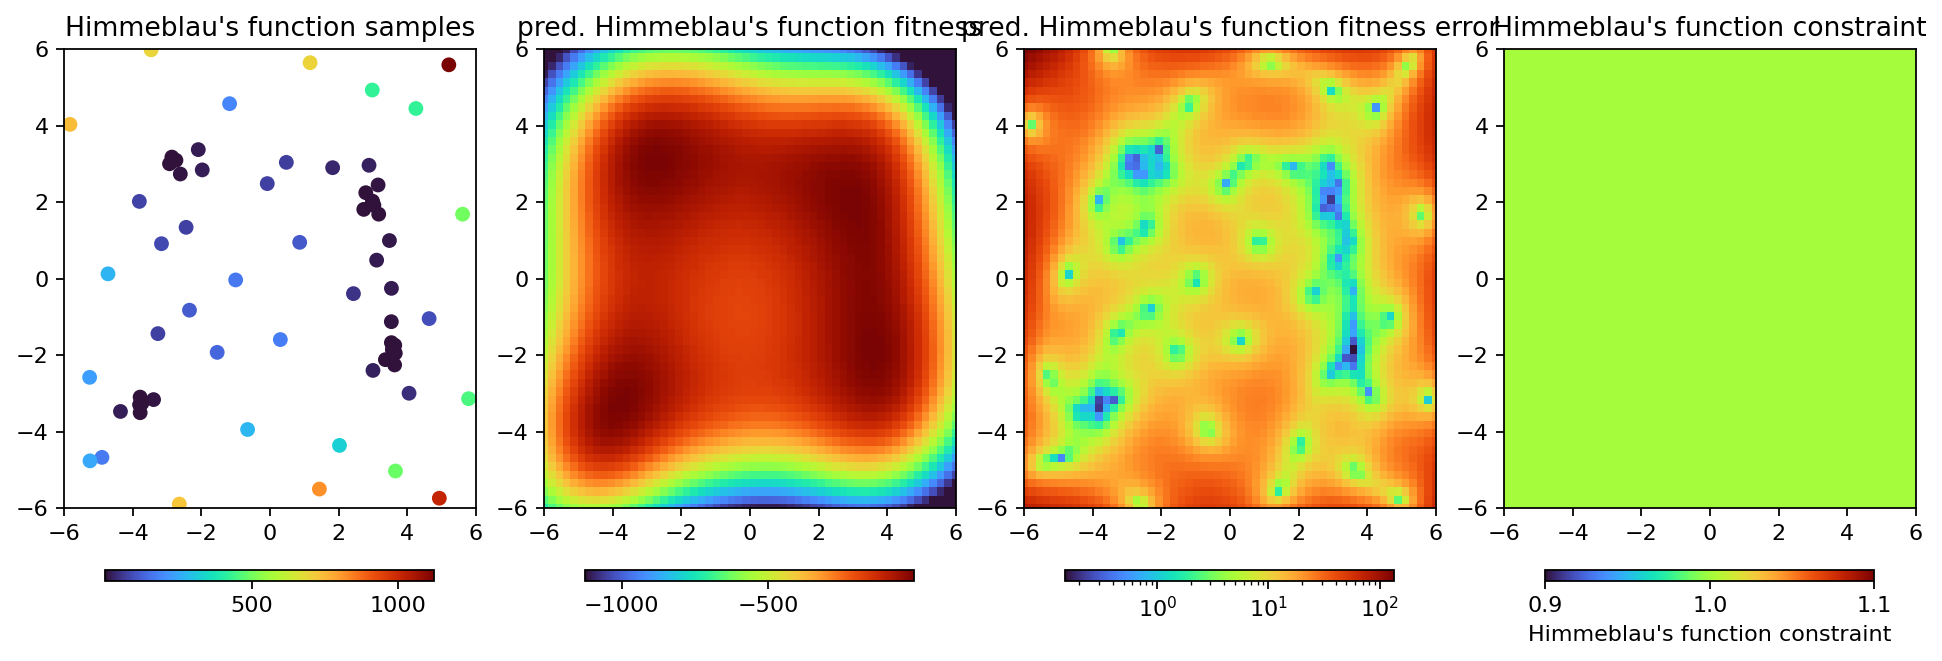

In [13]:
agent.plot_objectives()
print(agent.best)